In [1]:

import os
print(os.listdir('../input'))


['aptos2019-blindness-detection']


In [2]:
import os
import pandas as pd
import shutil

# Define paths
data_csv = '/kaggle/input/aptos2019-blindness-detection/train.csv'  # CSV file containing image names and labels
image_folder = '/kaggle/input/aptos2019-blindness-detection/train_images'  # Folder where images are stored
output_folder = '/kaggle/working/classified_images'  # Folder where the classified images will be stored

# Load the CSV file
df = pd.read_csv(data_csv)

# Ensure the output folder exists, if not create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create directories for the classes (0 to 4)
class_names = [0, 1, 2, 3, 4]
for class_name in class_names:
    class_dir = os.path.join(output_folder, str(class_name))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Loop through the dataset and copy images to the respective class folders
for index, row in df.iterrows():
    image_name = row['id_code'] + '.png'  # Assuming images have .png extension
    label = row['diagnosis']  # Label column representing classes 0 to 4

    # Define source and destination paths
    src_path = os.path.join(image_folder, image_name)
    dest_path = os.path.join(output_folder, str(label), image_name)

    # Copy the image to the respective class folder
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)  # Use copy instead of move
    else:
        print(f"Image {image_name} not found.")

print("Images have been copied into respective class folders.")

Images have been copied into respective class folders.


In [4]:
!ls

classified_images


In [4]:
!ls 

classified_images


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/classified_images',
    image_size=(224, 224),  # Resize images to a consistent size
    batch_size=32,          # Batch size for training
    label_mode='int',       # Labels as integers
    shuffle=True,           # Shuffle the data
    seed=42

)

Found 3662 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
print(class_names)

['0', '1', '2', '3', '4']


In [7]:
import tensorflow as tf

def split_dataset(ds, train_split=0.7, val_split=0.15, test_split=0.15, seed=42):
    

    # Calculate dataset sizes
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  # Remaining samples for test set

    # Shuffle and split the dataset
    ds = ds.shuffle(ds_size, seed=seed)

    # Take subsets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds

# Example of usage with caching and prefetching for better performance
def prepare_datasets(train_ds, val_ds, test_ds):
    
    AUTOTUNE = tf.data.AUTOTUNE

    # Cache and prefetch for performance
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds

# Assume you have a dataset 'dataset'
train_ds, val_ds, test_ds = split_dataset(dataset)
train_ds, val_ds, test_ds = prepare_datasets(train_ds, val_ds, test_ds)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [9]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)


base_model.trainable = False
# Extract features using EfficientNetB0
def extract_features(dataset, model):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        batch_features = model.predict(batch_images)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
        features.append(batch_features)
        labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features for training, validation, and test sets
X_train, y_train = extract_features(train_ds, base_model)
X_val, y_val = extract_features(val_ds, base_model)
X_test, y_test = extract_features(test_ds, base_model)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1727721189.549354     114 service.cc:145] XLA service 0x7c6b500460e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727721189.549404     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727721189.549410     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


I0000 00:00:1727721196.486068     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [10]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization,Dropout, Dense
import matplotlib.pyplot as plt
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build the MLP model
mlp_model = Sequential([
    Dense(1024, activation='elu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(512, activation='elu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='elu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='elu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='elu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='elu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(len(class_names), activation='softmax')  # Output layer
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
mlp_model.compile(optimizer='adam',  # Adam optimizer
                  loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
                  metrics=['accuracy'])  # Metric to monitor

# Train the model
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    64,226,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,933,893 (247.70 MB)

 Trainable params: 64,929,861 (247.69 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [14]:
history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)
# Make predictions on the test set

mlp_model.evaluate(X_test, y_test)

y_pred = np.argmax(mlp_model.predict(X_test), axis=1)
print(y_pred)
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

Epoch 1/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9658 - loss: 0.1126 - val_accuracy: 0.9173 - val_loss: 0.2704
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9606 - loss: 0.1549 - val_accuracy: 0.9449 - val_loss: 0.2152
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9539 - loss: 0.1565 - val_accuracy: 0.9320 - val_loss: 0.2645
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9683 - loss: 0.1101 - val_accuracy: 0.9357 - val_loss: 0.2195
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9730 - loss: 0.0980 - val_accuracy: 0.9393 - val_loss: 0.2633
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9590 - loss: 0.1380 - val_accuracy: 0.9412 - val_loss: 0.2482
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9590 - loss: 0.1578 - val_accuracy: 0.9412 - val_loss: 0.2691
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9616 - loss: 0.1425 - val_accuracy: 0.9467 - v

Images copied to respective class folders.
Found 3662 files belonging to 5 classes.
Class names: ['0', '1', '2', '3', '4']


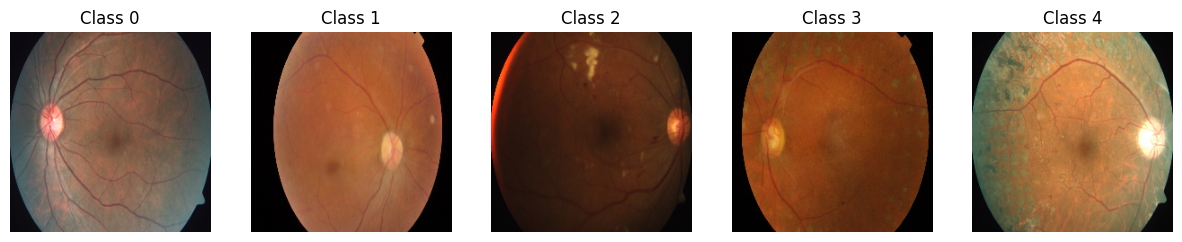

In [4]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Step 1: Load and organize dataset images into class folders
data_csv = '/kaggle/input/aptos2019-blindness-detection/train.csv'  # CSV file containing image names and labels
image_folder = '/kaggle/input/aptos2019-blindness-detection/train_images'  # Folder where images are stored
output_folder = '/kaggle/working/classified_images'  # Folder where the classified images will be stored

df = pd.read_csv(data_csv)

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create directories for the classes (0 to 4)
class_names = [0, 1, 2, 3, 4]
for class_name in class_names:
    class_dir = os.path.join(output_folder, str(class_name))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Copy images to respective class folders
for index, row in df.iterrows():
    image_name = row['id_code'] + '.png'  # Assuming images have .png extension
    label = row['diagnosis']
    src_path = os.path.join(image_folder, image_name)
    dest_path = os.path.join(output_folder, str(label), image_name)
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"Image {image_name} not found.")

print("Images copied to respective class folders.")

# Step 2: Load and preprocess dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    output_folder,
    image_size=(224, 224),  # Resize images
    batch_size=32,          # Batch size for training
    label_mode='int',       # Labels as integers
    shuffle=True,
    seed=42
)
class_names = dataset.class_names
print("Class names:", class_names)
def plot_images_by_class(dataset, class_names, num_images=1):
    plt.figure(figsize=(15, 15))
    
    # Iterate through each class
    for class_idx, class_name in enumerate(class_names):
        class_images = []
        
        # Collect images for each class
        for image_batch, label_batch in dataset:
            for img, label in zip(image_batch, label_batch):
                if label == class_idx:
                    class_images.append(img)
                if len(class_images) == num_images:
                    break
            if len(class_images) == num_images:
                break
        
        # Plot the images horizontally
        for i, img in enumerate(class_images):
            plt.subplot(num_images, len(class_names), i * len(class_names) + class_idx + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(f"Class {class_name}")
            plt.axis('off')
    
    plt.show()

# Plot 5 images per class arranged horizontally
plot_images_by_class(dataset, class_names, num_images=1)

# Split dataset
def split_dataset(ds, train_split=0.7, val_split=0.15, test_split=0.15, seed=42):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size
    ds = ds.shuffle(ds_size, seed=seed)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)

# Cache and prefetch datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [5]:
# Step 3: Feature extraction using EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)
base_model.trainable = False

def extract_features(dataset, model):
    features, labels = [], []
    for batch_images, batch_labels in dataset:
        batch_features = model.predict(batch_images)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
        features.append(batch_features)
        labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

X_train, y_train = extract_features(train_ds, base_model)
X_val, y_val = extract_features(val_ds, base_model)
X_test, y_test = extract_features(test_ds, base_model)

# Step 4: Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Step 5: Build and train MLP model
mlp_model = Sequential([
    Dense(1024, activation='elu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='elu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='elu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='elu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='elu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='elu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')  # Output layer
])

mlp_model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Step 6: Evaluate model and print classification report
mlp_model.evaluate(X_test, y_test)
y_pred = np.argmax(mlp_model.predict(X_test), axis=1)
report = classification_report(y_test, y_pred, target_names=[str(x) for x in class_names])
print(report)

# Step 7: Visualize images with Grad-CAM
def plot_images_with_predictions(images, true_labels, predicted_labels, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Display first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f'True: {true_label}, Predicted: {predicted_label}')
        plt.axis('off')
    plt.show()




16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1729064862.857602     104 service.cc:145] XLA service 0x7d32f0002fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729064862.859087     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729064862.859093     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


I0000 00:00:1729064870.155006     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 60s 582ms/step - accuracy: 0.4011 - loss: 1.6906 - val_accuracy: 0.7426 - val_loss: 0.8992
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6227 - loss: 1.0585 - val_accuracy: 0.7757 - val_loss: 0.6662
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.6621 - loss: 0.9193 - val_accuracy: 0.7757 - val_loss: 0.6052
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.6898 - loss: 0.8157 - val_accuracy: 0.7868 - val_loss: 0.5566
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7251 - loss: 0.7552 - val_accuracy: 0.7996 - val_loss: 0.5379
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.7572 - loss: 0.6565 - val_accuracy: 0.7996 - val_loss: 0.5061
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7757 - loss: 0.6274 - val_accuracy: 0.8033 - val_loss: 0.5033
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.7862 - loss: 0.6081 - val_accuracy: 

In [13]:
print("Shape of X_test:", X_test.shape)


Shape of X_test: (558, 62720)
